In [267]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import random
import pandas as pd

# Extract dataset
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}


# Create custom min-max scaler
def min_max_scaler(train_data, test_data, new_min, new_max):
    min_value = min([train_data.min(), test_data.min()])
    max_value = max([train_data.max(), test_data.max()])
    scale = (max_value - min_value) / (new_max - new_min)
    scaled_dataset = (train_data - min_value) / scale + new_min, (test_data - min_value) / scale + new_min
    return scaled_dataset

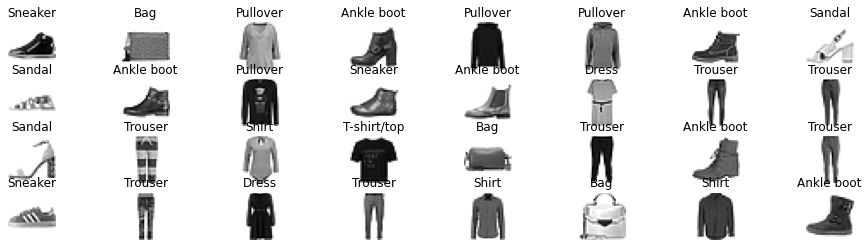

In [268]:
plt.figure(figsize=(16, 4))
for _ in range(8*4):
    ax = plt.subplot(4, 8, _+1)
    choice = random.choice(range(len(train_data)))
    plt.imshow(train_data[choice], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[choice]])
    plt.axis(False)

In [269]:
# Scale data to use it with ELU activation
train_data, test_data = min_max_scaler(train_data, test_data, -1, 5)
train_data.min(), train_data.max()

(-1.0, 5.0)

* Input shape = train_data.shape = image resulution X number of color channels
* Output shape = len(class_names)
* Loss function = tf.keras.losses.CategoricalCrossentropy for one-hot encoded labels or SparseCategoricalCrossentropy for integer labels
* Output layer activation = Softmax

In [279]:
tf.random.set_seed(42)
# elu = tf.keras.activations.elu

model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(40, activation="elu"),
    tf.keras.layers.Dense(40, activation="sigmoid"),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=["accuracy"])

history_1 = model_1.fit(train_data,
                        train_labels,
                        epochs=15,
                        batch_size=200,
                        validation_data=(test_data, test_labels))


Epoch 1/15
300/300 [==============================] - 1s 2ms/step - loss: 0.7775 - accuracy: 0.7837 - val_loss: 0.5142 - val_accuracy: 0.8313
Epoch 2/15
300/300 [==============================] - 0s 1ms/step - loss: 0.4398 - accuracy: 0.8527 - val_loss: 0.4358 - val_accuracy: 0.8499
Epoch 3/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3823 - accuracy: 0.8671 - val_loss: 0.4074 - val_accuracy: 0.8563
Epoch 4/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3542 - accuracy: 0.8750 - val_loss: 0.3868 - val_accuracy: 0.8633
Epoch 5/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3334 - accuracy: 0.8824 - val_loss: 0.3752 - val_accuracy: 0.8658
Epoch 6/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3187 - accuracy: 0.8855 - val_loss: 0.3691 - val_accuracy: 0.8685
Epoch 7/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3047 - accuracy: 0.8900 - val_loss: 0.3582 - val_accuracy: 0.8754
Epoch 

<AxesSubplot:>

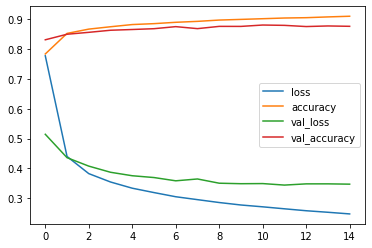

In [271]:
pd.DataFrame(history_1.history).plot()

In [272]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(40, activation="elu"),
    tf.keras.layers.Dense(40, activation="sigmoid"),
    tf.keras.layers.Dense(10, activation="softmax")
])


model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))


find_lr_history = model_2.fit(train_data, train_labels,
                            epochs=40,
                            batch_size=200,
                            validation_data=(test_data, test_labels),
                            callbacks=[lr_scheduler]
                           )

Epoch 1/40
300/300 [==============================] - 1s 2ms/step - loss: 0.7775 - accuracy: 0.7837 - val_loss: 0.5142 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 2/40
300/300 [==============================] - 0s 1ms/step - loss: 0.4390 - accuracy: 0.8526 - val_loss: 0.4345 - val_accuracy: 0.8497 - lr: 0.0011
Epoch 3/40
300/300 [==============================] - 0s 1ms/step - loss: 0.3799 - accuracy: 0.8674 - val_loss: 0.4006 - val_accuracy: 0.8598 - lr: 0.0013
Epoch 4/40
300/300 [==============================] - 0s 1ms/step - loss: 0.3542 - accuracy: 0.8744 - val_loss: 0.3837 - val_accuracy: 0.8636 - lr: 0.0014
Epoch 5/40
300/300 [==============================] - 0s 1ms/step - loss: 0.3349 - accuracy: 0.8796 - val_loss: 0.3727 - val_accuracy: 0.8672 - lr: 0.0016
Epoch 6/40
300/300 [==============================] - 0s 1ms/step - loss: 0.3209 - accuracy: 0.8832 - val_loss: 0.3777 - val_accuracy: 0.8613 - lr: 0.0018
Epoch 7/40
300/300 [==============================] - 0s 1ms/step - lo

Text(0, 0.5, 'Loss')

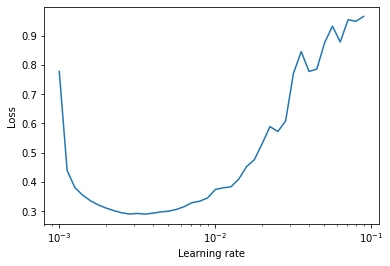

In [273]:
lrs = 1e-3 * (10 ** (tf.range(40) / 20))
plt.semilogx(lrs, find_lr_history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")